In [1]:
import numpy as np
import mrcfile
import matplotlib.pyplot as plt
%matplotlib notebook

In [13]:
class SubgraphLoader():
    def __init__(self, 
                 inputShape, 
                 sampleShape, 
                 keys, 
                 keyToPath,
                 labelFile):
        self.inputShape = inputShape
        self.sampleShape = sampleShape
        self.keys = keys
        self.keyToPath = keyToPath
        self.particles = self._parseParticles(labelFile)
    
    def getMicrograph(self, key):
        """ Load micrograph. """
        with mrcfile.open(self.keyToPath(key), permissive=True) as mrc:
            data = mrc.data
        return data
    
    def boxContains(self, point, sampleId):
        dimH, dimW = self.sampleShape 
        x, y = point
        cx, cy = sampleId
        return (cx*dimW < x < cx*dimW + dimW) and (cy*dimH < y < cy*dimH + dimH)
    
    def _generateSubgraph(self, key):
        """ Generate the subimages for a given micrograph. """
        retDict = {}
        h, w = self.inputShape
        dimH, dimW = self.sampleShape
        data = self.getMicrograph(key)
        for idxh in range(int(h/dimH)):
            for idxw in range(int(w/dimW)):
                retDict[(idxh,idxw)] = data[idxh*dimH:idxh*dimH+dimH, 
                                                  idxw*dimW:idxw*dimW+dimW]
        return retDict

    def _parseParticles(self, file):
        """ 
        Read in the particles for all micrographs. 
        This will need to be edited if you change your key types. 
        """
        with open(file, "r") as f:
            particles = f.readlines()

        particleData = [particle.split()[0:3] for particle in particles[17:-1]]
        particleDict = {}
        for x in particleData:
            key = int(x[0][18:22])
            value = tuple(map(float, x[1:]))
            particleDict.setdefault(key, []).append(value)
        return particleDict

    def getSubgraphAnnotation(self, shift = True):
        """ 
        Searches through the particle list a dictionary which maps
                
        (micrographKey, subgraphKey) -> [particles in subgraph]

        subgraphKey - is the x,y position of a subgraph within the grid formed by the subgraphs over the micrograph.
        shift specifies if you want the absolute or relative posiotions.
        """
        subDict = {}
        h, w = self.inputShape
        dimH, dimW = self.sampleShape
        for micrograph in self.keys:
            for idxh in range(int(h/dimH)):
                for idxw in range(int(w/dimW)):
                    subgraph_particles = np.array(
                        list(
                            filter(
                                lambda x : boxContains(x, (idxh, idxw)), 
                                self.particles[micrograph]
                            )
                        )
                    )
                    try:
                        subDict[(micrograph, idxh, idxw)] = subgraph_particles - np.array([idxh*dimH, idxw*dimW])*shift
                    except:
                        continue
        return subDict
    
    def getSubgraphs(self):
        subDict = {}
        for micrograph in self.keys:
            subgraphs = self._generateSubgraph(micrograph)
            for k,v in subgraphs.items():
                subDict[(micrograph, *k)] = v
        return subDict

In [14]:
loader = SubgraphLoader (
    (3710, 3838), 
    (512, 512), 
    [1, 2, 3], 
    lambda x: f'../data/full/stack_{str(x).zfill(4)}_2x_dfpt.mrc',
    '../data/full/particles.star'
)

In [15]:
subgraphs = loader.getSubgraphs()
annotations = loader.getSubgraphAnnotation()
abs_annotations = loader.getSubgraphAnnotation(False)

NameError: name 'boxContains' is not defined

<IPython.core.display.Javascript object>


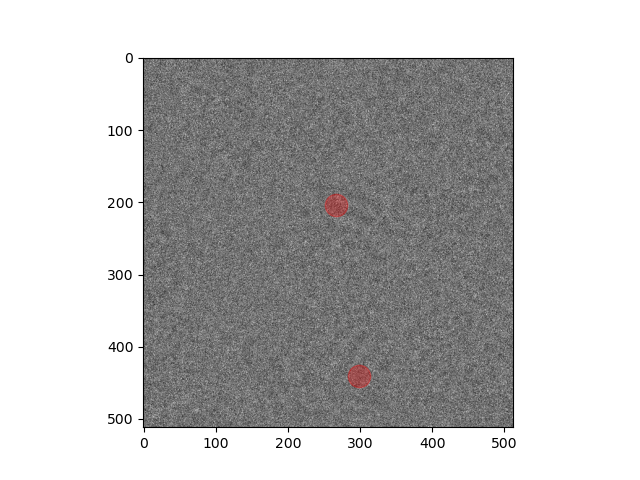

In [301]:
key = (1,0,0)
plt.figure()
plt.imshow(subgraphs[key], cmap='gray')
plt.scatter(*zip(*annotations[key]), c='red', alpha=0.3, s=260)

In [298]:
particles = loader._parseParticles('../data/full/particles.star')

In [303]:
from matplotlib.patches import Rectangle

<IPython.core.display.Javascript object>


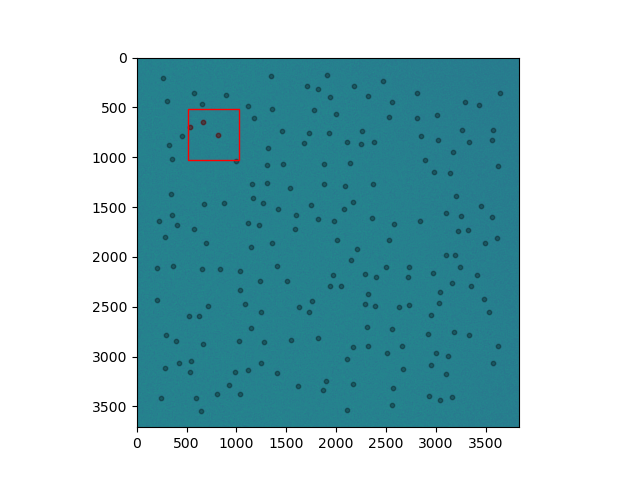

In [310]:
outdir = '../data/full/'
fname = 'stack_0001_2x_dfpt.mrc'
with mrcfile.open(f'{outdir}{fname}', permissive=True) as mrc:
    data = mrc.data

key = (1,1,1)
dim = 512

plt.figure()
plt.imshow(data)
plt.scatter(*zip(*abs_annotations[key]), c='red', alpha=0.3, s=10)
plt.scatter(*zip(*particles[key[0]]), c='black', alpha=0.3, s=10)
rect = Rectangle((key[1]*dim,key[2]*dim), dim, dim,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.gca().add_patch(rect)